### Presenting a solution to get into top 7% of leaderboard using Support Vector Classifier with an accuracy score of 0.81063

<center><img src="https://media3.s-nbcnews.com/j/newscms/2019_41/3044956/191009-cooking-vegetables-al-1422_ae181a762406ae9dce02dd0d5453d1ba.nbcnews-fp-1200-630.jpg" alt="Cooking Image from Google"></center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import json
import re
import nltk
import zipfile

from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
for t in ['train','test']:
    with zipfile.ZipFile("../data/{}.json.zip".format(t),"r") as z:
        z.extractall(".")
    
with open('./train.json', encoding='utf8') as data_file:    
    data = json.load(data_file)
    
with open('./test.json', encoding='utf8') as test_file:
    test = json.load(test_file)

In [3]:
df = pd.DataFrame(data)
test_df = pd.DataFrame(test)

test_ids = test_df['id']

df.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


# EDA

In [4]:
(df.isnull().sum() / len(df))*100 # No null values in train

id             0.0
cuisine        0.0
ingredients    0.0
dtype: float64

In [5]:
(test_df.isnull().sum() / len(test_df))*100 # No null values in test

id             0.0
ingredients    0.0
dtype: float64

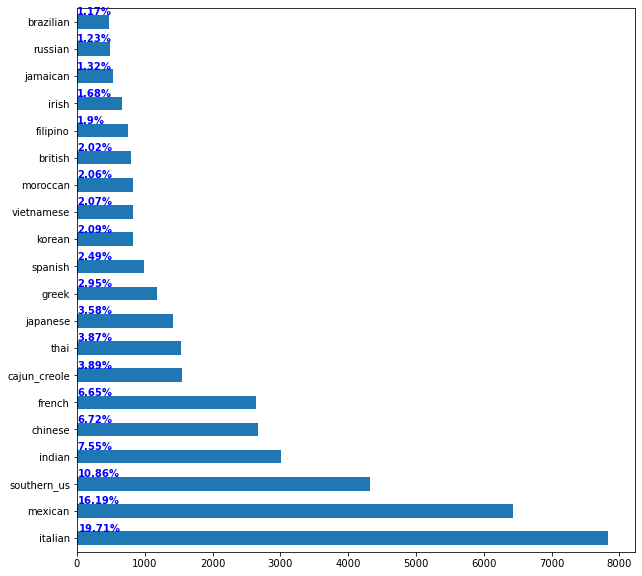

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
per_vals = round(df["cuisine"].value_counts(normalize=True)*100, 2)
for i, v in enumerate(per_vals):
    ax.text(v + 3, i + .25, str(v)+"%", color='blue', fontweight='bold')
df["cuisine"].value_counts().plot.barh(ax = ax)
plt.show()

<AxesSubplot:>

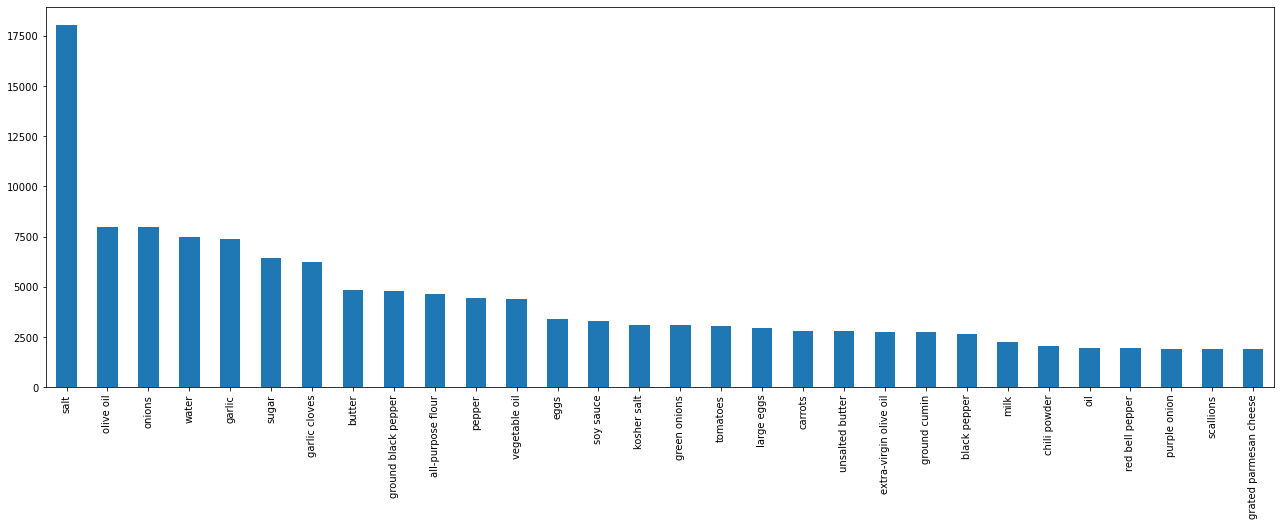

In [7]:
fig, ax = plt.subplots(figsize=(22,7))
extensive_ing_list = []
for x in df['ingredients']:
    for y in x:
        extensive_ing_list.append(y)
        
extensive_ing_list = pd.Series(extensive_ing_list)
extensive_ing_list.value_counts().sort_values(ascending=False).head(30).plot.bar(ax = ax)

### Creating ingredients per cuisine

In [8]:
cuisine = df["cuisine"].unique()

all_cus = dict()
for cs in cuisine:
    i = []
    for ing_list in df[df['cuisine']==cs]['ingredients']:
        for ing in ing_list:
            i.append(ing)
    all_cus[cs] = i

all_cus.keys()

dict_keys(['greek', 'southern_us', 'filipino', 'indian', 'jamaican', 'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai', 'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese', 'irish', 'korean', 'moroccan', 'russian'])

#### 25 MOST USED INGREDIENTS- CUISINE WISE

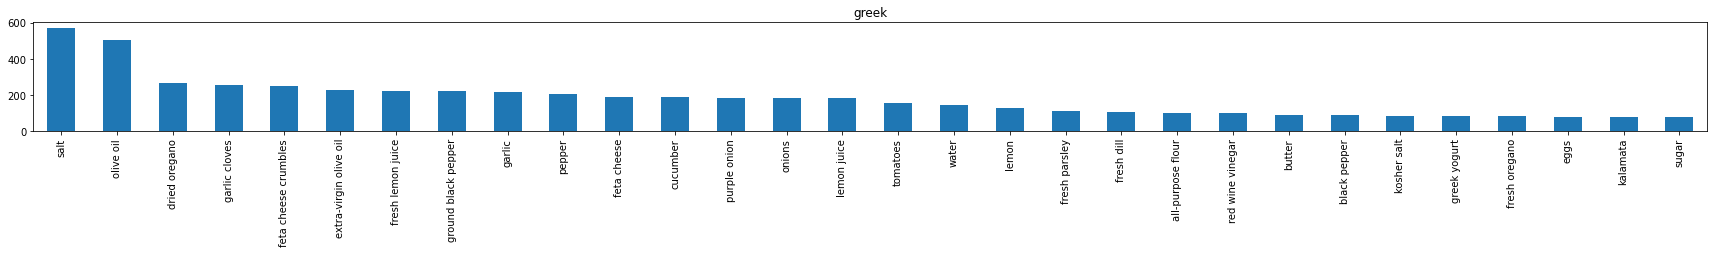

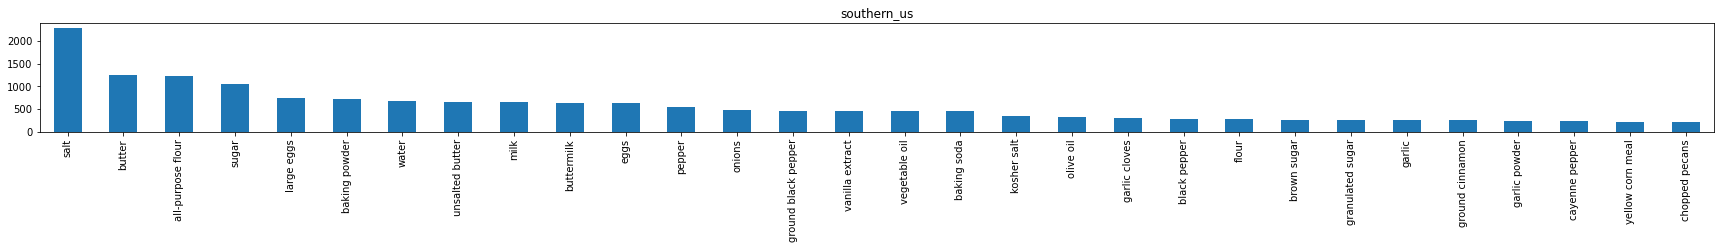

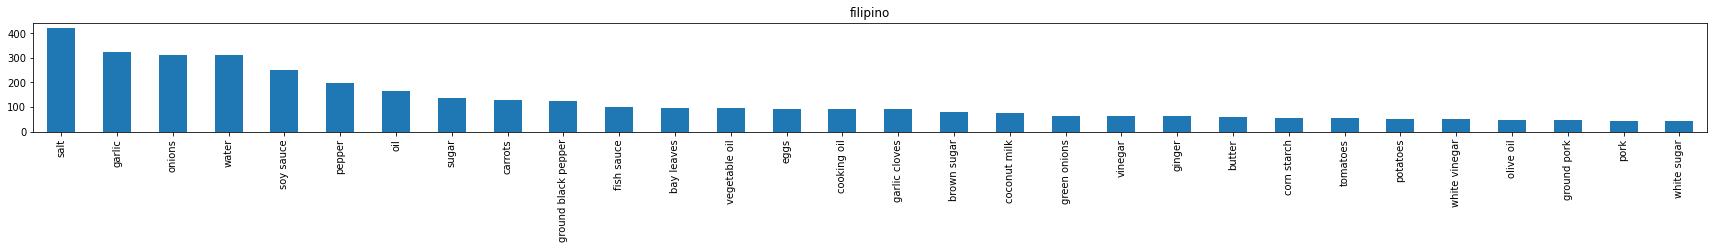

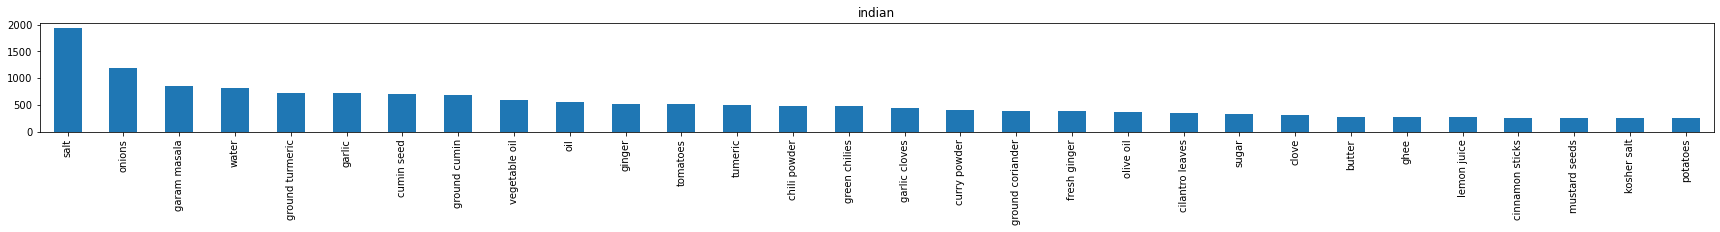

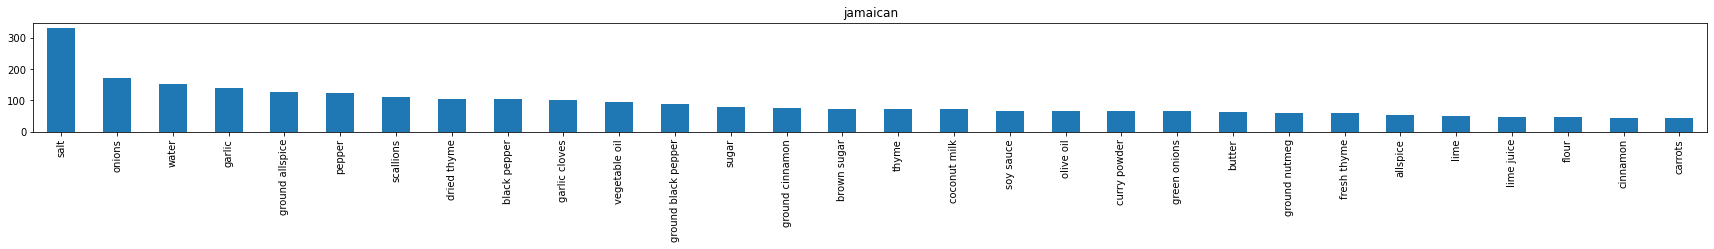

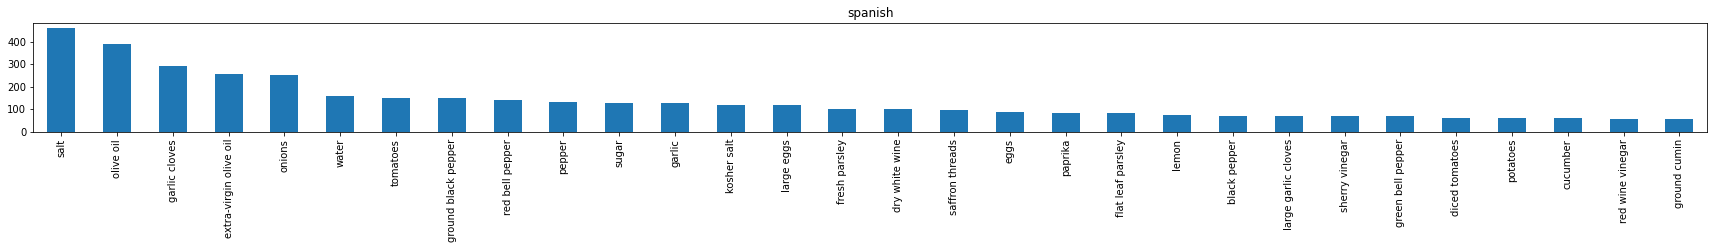

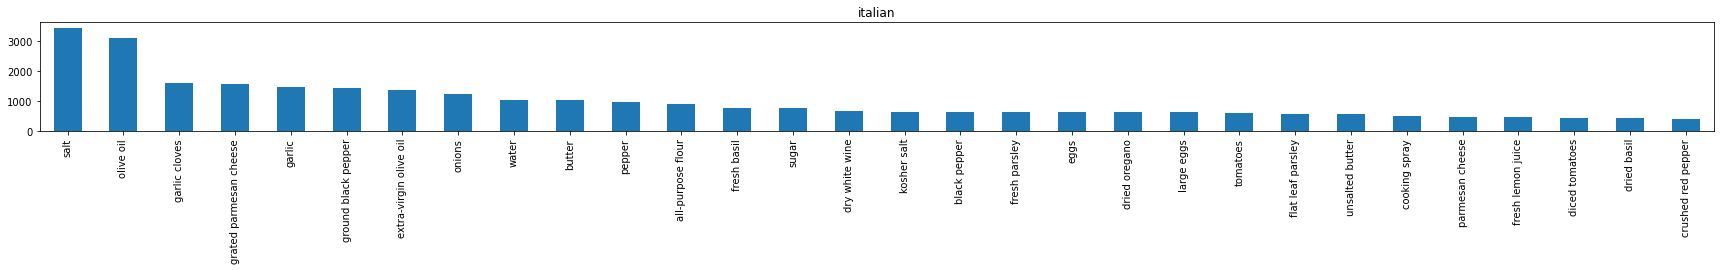

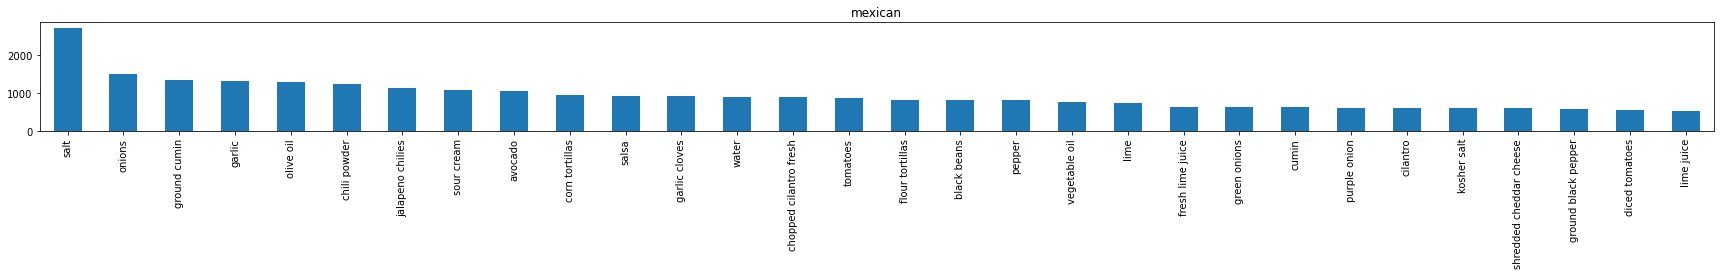

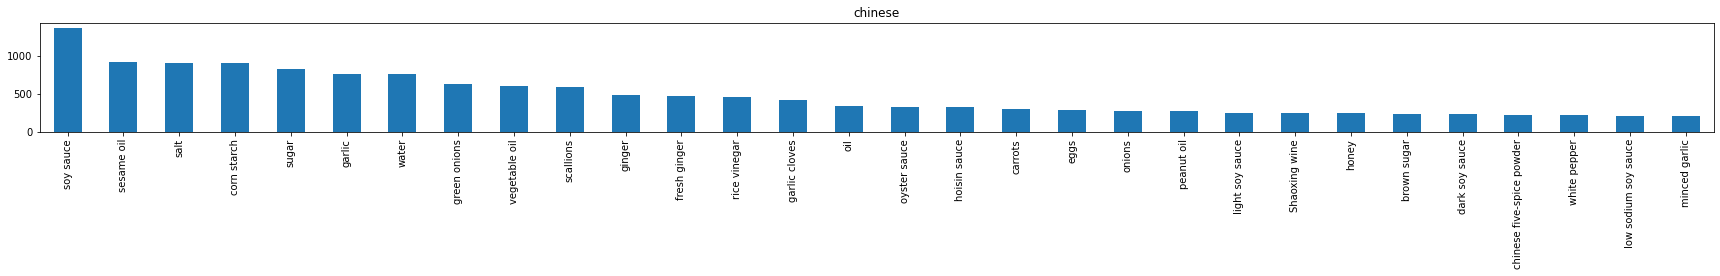

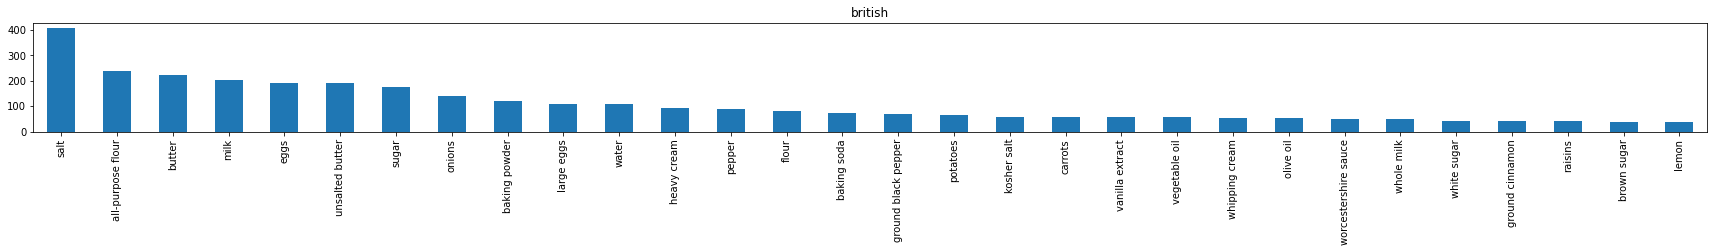

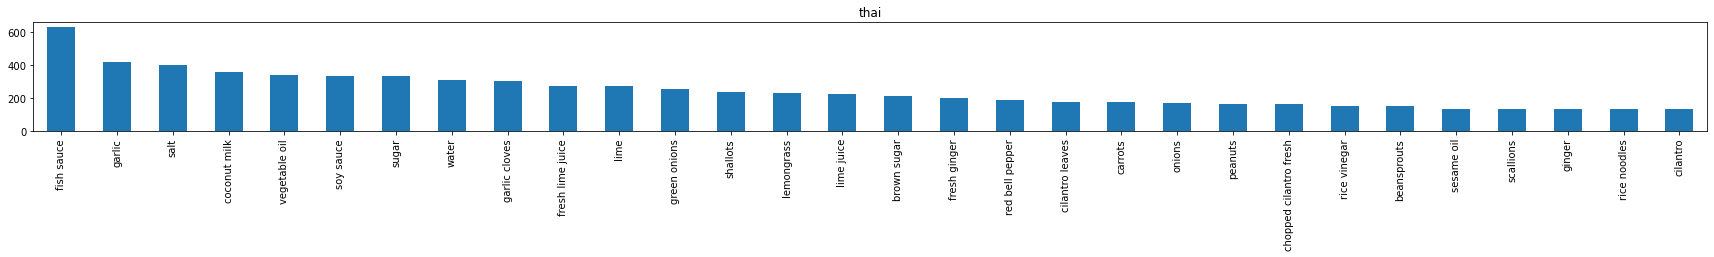

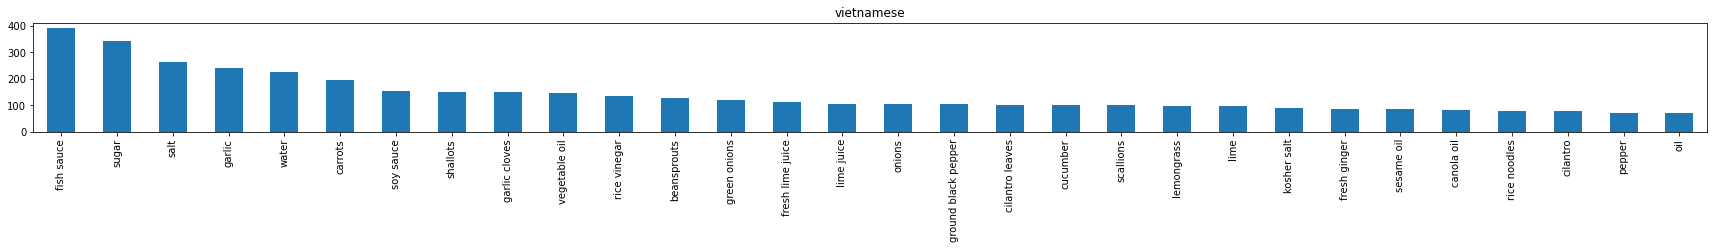

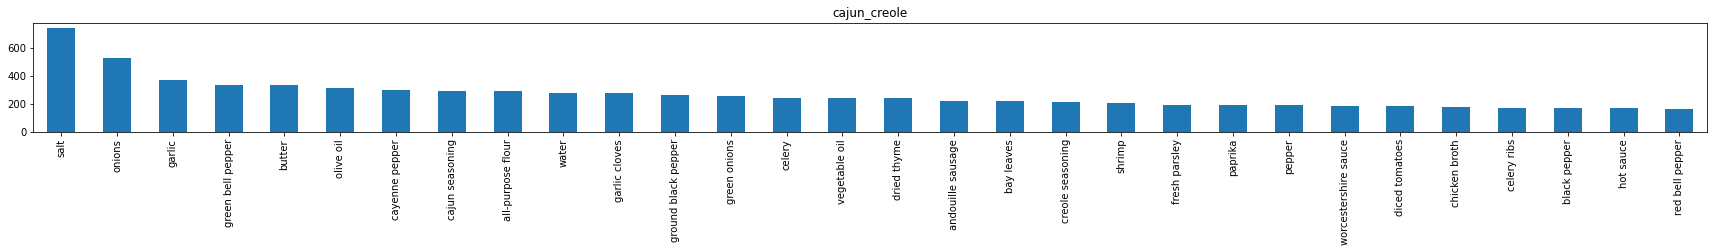

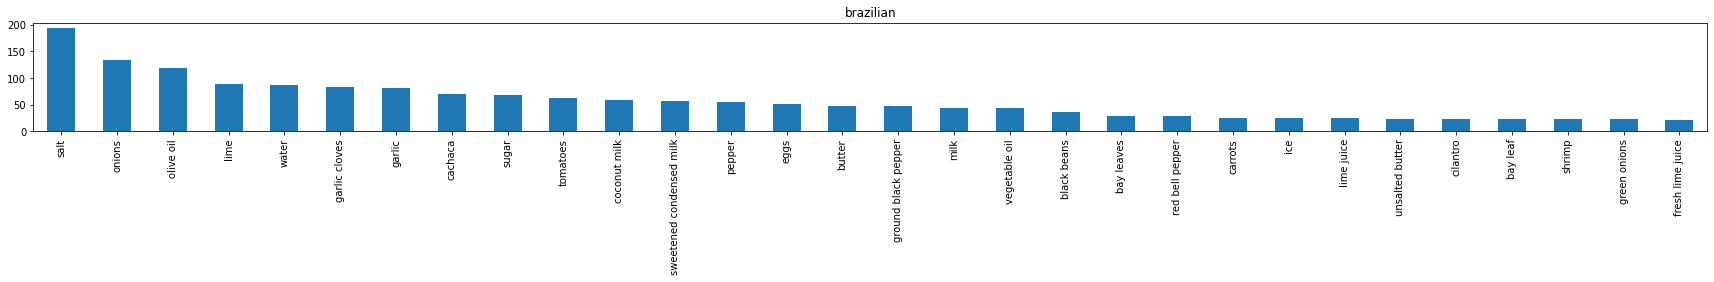

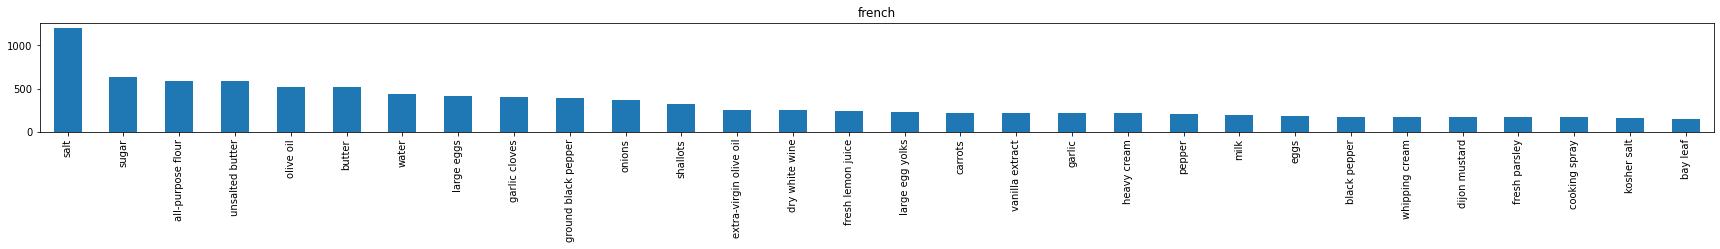

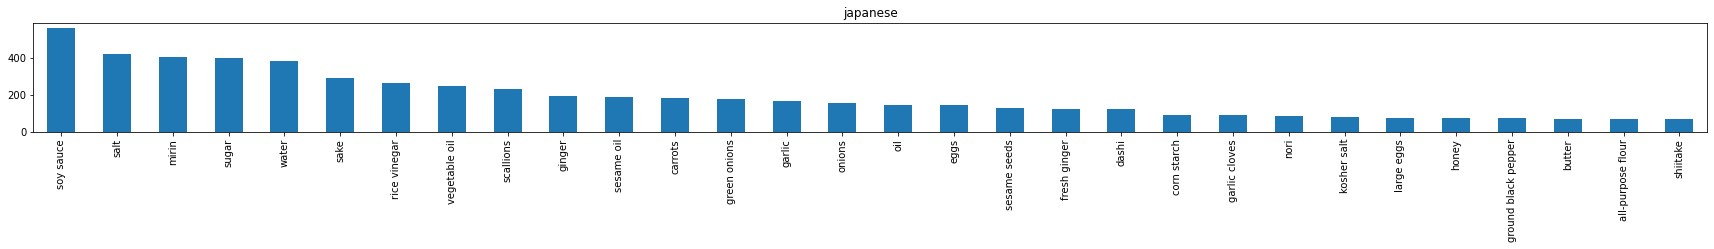

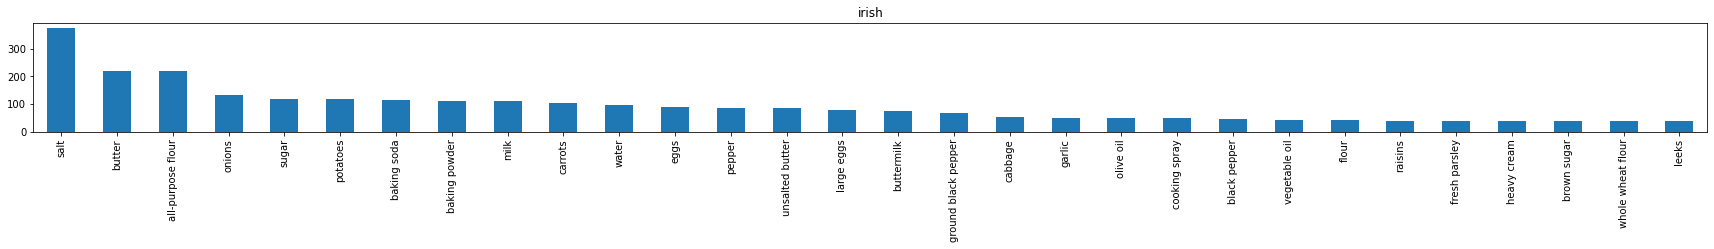

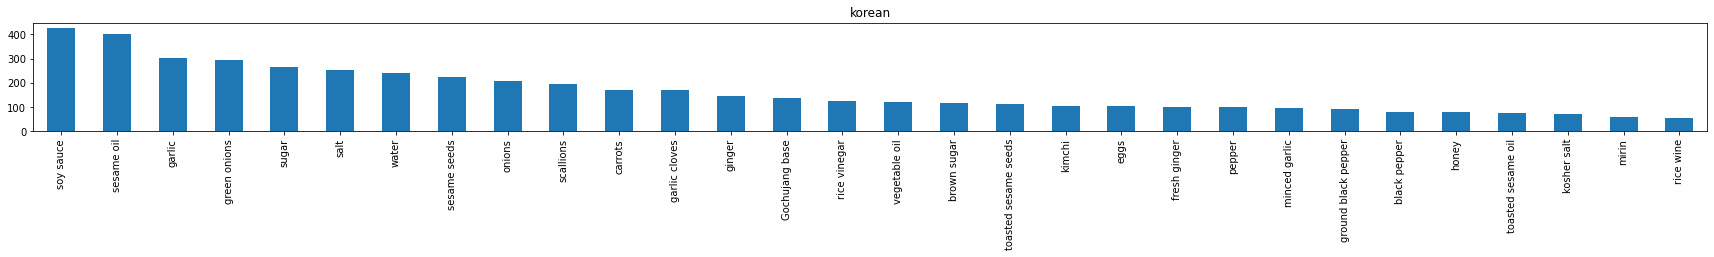

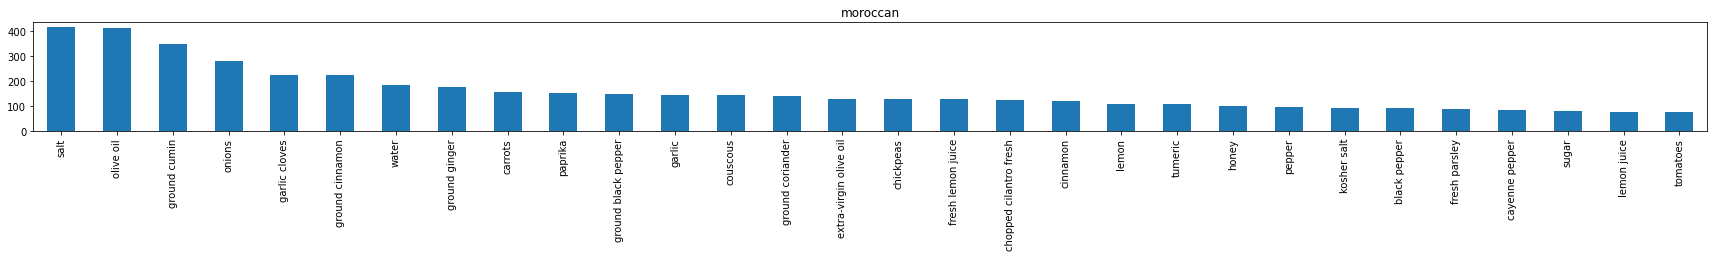

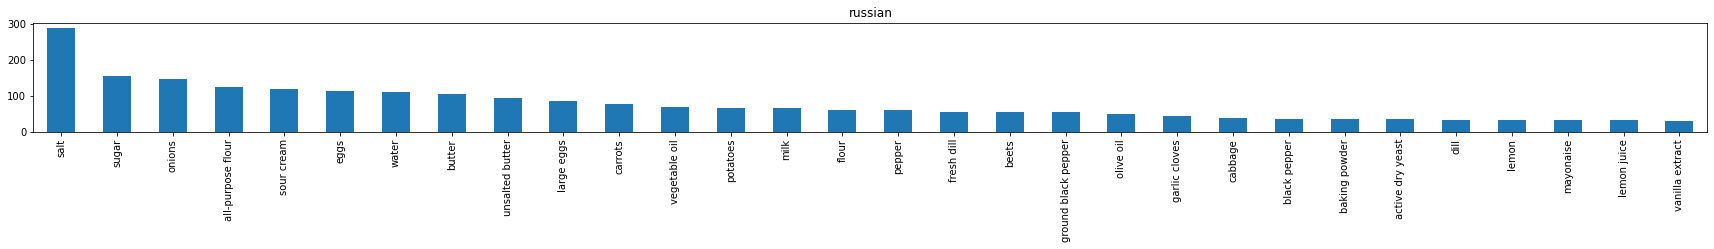

In [9]:
for key in all_cus.keys():
    fig, ax = plt.subplots(figsize=(30,2))
    pd.Series(all_cus[key]).value_counts().head(30).plot.bar(ax=ax, title=key)
    plt.show()

#### DELETE GENERAL INGREDIENTS

In [10]:
most_used = pd.Series(data=np.arange(20))
general_ing = []
for key in all_cus.keys():
    most_used = pd.Series(all_cus[key]).value_counts().head(20)
    if len(general_ing) != 0:
        general_ing = list(set(most_used.index).intersection(set(general_ing)))
    else:
        general_ing = most_used.index
print(general_ing)

['water', 'salt']


In [11]:
for row in (df['ingredients']):
    for ing in general_ing:
        if ing in row: row.remove(ing)
df

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, tomatoes, ground ..."
2,20130,filipino,"[eggs, pepper, mayonaise, cooking oil, green c..."
3,22213,indian,"[vegetable oil, wheat]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."
...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b..."
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli..."


In [12]:
for row in (test_df['ingredients']):
    for ing in general_ing:
        if ing in row: row.remove(ing)
test_df

,id,ingredients
0,18009,"[baking powder, eggs, all-purpose flour, raisi..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil..."
3,29752,"[meat cuts, file powder, smoked sausage, okra,..."
4,35687,"[ground black pepper, sausage casings, leeks, ..."
...,...,...
9939,30246,"[large egg yolks, fresh lemon juice, sugar, bo..."
9940,36028,"[hot sauce, butter, sweet potatoes, adobo sauce]"
9941,22339,"[black pepper, parmigiano reggiano cheese, ric..."
9942,42525,"[cheddar cheese, cayenne, paprika, plum tomato..."


# Preprocessing

### String Preprocess

In [13]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
def preprocess_df(df):
    
    def process_string(x):
        x = [" ".join([WordNetLemmatizer().lemmatize(q) for q in p.split()]) for p in x] #Lemmatization
        x = list(map(lambda x: re.sub(r'\(.*oz.\)|crushed|crumbles|ground|minced|powder|chopped|sliced','', x), x))
        x = list(map(lambda x: re.sub("[^a-zA-Z]", " ", x), x))   # To remove everything except a-z and A-Z
        x = " ".join(x)                                 # To make list element a string element 
        x = x.lower()
        return x
    
    df = df.drop('id',axis=1)
    df['ingredients'] = df['ingredients'].apply(process_string)
    
    return df

In [15]:
def get_cuisine_cumulated_ingredients(df):
    cuisine_df = pd.DataFrame(columns=['ingredients'])

    for cus in cuisine:
        st = ""
        for x in df[df.cuisine == cus]['ingredients']:
            st += x
            st += " "
        cuisine_df.loc[cus,'ingredients'] = st

    cuisine_df = cuisine_df.reset_index()
    cuisine_df = cuisine_df.rename(columns ={'index':'cuisine'})

    return cuisine_df

In [16]:
df = preprocess_df(df)
test_df = preprocess_df(test_df)

cuisine_df = get_cuisine_cumulated_ingredients(df)

In [17]:
df.head()

,cuisine,ingredients
0,greek,romaine lettuce black olive grape tomato garli...
1,southern_us,plain flour pepper tomato black pepper thyme...
2,filipino,egg pepper mayonaise cooking oil green chilies...
3,indian,vegetable oil wheat
4,indian,black pepper shallot cornflour cayenne pepper ...


In [18]:
train = df['ingredients']
target = df['cuisine']
test = test_df['ingredients']

## Count Vectorizer

In [19]:
def count_vectorizer(train, test=None):
    cv = CountVectorizer()
    train = cv.fit_transform(train)
    if test is not None:
        test = cv.transform(test)
        return train, test, cv
    else:
        return train, cv

In [20]:
# train_cv , test_cv, cv = count_vectorizer(train,test)
# cuisine_data_cv, cuisine_cv = count_vectorizer(cuisine_df['ingredients'])

## TFiDF Vectorizer

In [21]:
def tfidf_vectorizer(train, test=None):
    tfidf = TfidfVectorizer(stop_words='english',
                             ngram_range = ( 1 , 1 ),analyzer="word", 
                             max_df = .57 , binary=False , token_pattern=r'\w+' , sublinear_tf=False)
    train = tfidf.fit_transform(train)
    if test is not None:
        test = tfidf.transform(test)
        return train, test, tfidf
    else:
        return train, tfidf

In [22]:
train_tfidf, test_tfidf, tfidf = tfidf_vectorizer(train,test)
cuisine_data_tfidf, cuisine_tfidf = tfidf_vectorizer(cuisine_df['ingredients'])

## Cluster as a parameter

There are 20 different types of cuisine to classify. It gives an intuition that certain groups of cuisine may have much more similarity than others. We can try to find such groups as well

In [23]:
from sklearn.cluster import KMeans
from sklearn.decomposition import KernelPCA,PCA,TruncatedSVD

def get_kmeans_wcss(data, n_limit=15): # Within cluster sum of squares (WCSS)
    wcss = [] 
    for i in range(1,n_limit):
        km = KMeans(init='k-means++', n_clusters=i, n_init=10)
        km.fit(data)
        wcss.append(km.inertia_)
    plt.title("Elbow Method")
    plt.plot(range(1, n_limit), wcss)
    plt.xlabel("Number of clusters")
    plt.ylabel("WCSS")
    return wcss
    
def kmeans(data, n):
    km = KMeans(init='k-means++', n_clusters=n, n_init=10)
    km = km.fit(data)
    return km.predict(data), km 


def get_PCA(data, n_components=5):
    pca = PCA(n_components = n_components)
    reduced_data = pca.fit_transform(data)
    explained_variance = pca.explained_variance_ratio_
    print(explained_variance)
    return reduced_data, pca, explained_variance

def get_kernel_PCA(data, n_components=5, kernel='rbf'):
    kpca = KernelPCA(n_components = 5, kernel = kernel)
    reduced_data = kpca.fit_transform(data)
#     explained_variance = kpca.explained_variance_ratio_
#     print(explained_variance)
#     return reduced_data, kpca, explained_variance
    return reduced_data, kpca

def get_TSVD(data, n_components=5, n_ittr=5, algorithm='randomized'):
    tsvd = TruncatedSVD(n_components=n_components, n_iter=n_ittr, algorithm=algorithm)
    reduced_data = tsvd.fit_transform(data)
    explained_variance = tsvd.explained_variance_ratio_
    print(explained_variance)
    return reduced_data, tsvd, explained_variance


def create_pca_graph(cluster_pca, red_pca, n_clus):
    c_mask = []
    c_x = []
    c_y = []
    c_z = []
    
    for i in range(0,n_clus):
        c_mask.append([x for x in cluster_pca==i])
    
    for i in range(0,n_clus):
        c_x.append([a[0] for a, b in zip(red_pca, c_mask[i]) if b])
        c_y.append([a[1] for a, b in zip(red_pca, c_mask[i]) if b])
        c_z.append([a[2] for a, b in zip(red_pca, c_mask[i]) if b])

    colours = ['red','blue','green','orange','purple','cyan','black','magenta']
    
#     for i in range(0,n_clus):
#         plt.scatter(c_x[i], c_y[i], s=30, c=colours[i], label='Cluster {}'.format(i)) 
        
        
#     for i in range(0,20):
#         label = label_list[i]
#         plt.annotate(label, (c_x[i],c_y[i]), textcoords="offset points", xytext=(0,10), # distance from text to points (x,y)
#                      ha='center') # horizontal alignment can be left, right or center
        
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    
    for i in range(0,n_clus):
        ax.scatter(c_x[i], c_y[i], c_z[i], s=30 ,c=colours[i], label='Cluster {}'.format(i))

    ax.set_title("Clusters of PCA")
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")
    ax.set_zlabel("PCA 3")
#     plt.xlabel("PCA 1")
#     plt.ylabel("PCA 2")
#     plt.zlabel("PCA 3")
    ax.legend()
    plt.show()

In order to visualize clusters, let us reduce the data using PCA

In [24]:
# red_tsvd, tsvd, var_tsvd = get_TSVD(train_cv,2)  #Used because train_cv is a sparse matrix. PCA won't work
# red_pca, pca, var_pca = get_PCA((train_cv).toarray(),2)
# red_pca, pca, var_pca = get_PCA((train_tfidf).toarray(),2)
# red_tsvd, tsvd, var_tsvd = get_TSVD(train_tfidf,2)  #Used because train_tfidf is a sparse matrix. PCA won't work
# red_kpca, kpca, var_kpca = get_kernel_PCA(train_cv,2)  #Uses excessive RAM

In [25]:
# red_cuisine_pca, cus_pca, var_cus_pca = get_kernel_PCA((cuisine_data_tfidf).toarray(),3)
red_cuisine_pca, cus_pca = get_kernel_PCA((cuisine_data_tfidf).toarray(),5)

Wall time: 1.14 s


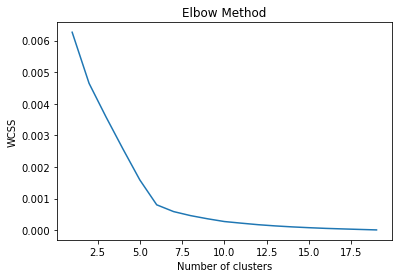

In [26]:
%%time
wcss_pca = get_kmeans_wcss(red_cuisine_pca,20)

WCSS for reduced cuisine dataset shows that number of clusters = 3 should be an apt choice (elbow point)

In [27]:
elbow_point = 6
cluster_cus_pca, km_cus_pca = kmeans(red_cuisine_pca,elbow_point)
cluster_cus_pca

array([0, 3, 1, 4, 4, 4, 0, 4, 1, 2, 1, 1, 3, 4, 0, 5, 2, 5, 4, 2])

In [28]:
# create_pca_graph(cluster_cus_pca, red_cuisine_pca, elbow_point)

We can notice there are 3 clusters of cuisines

In [31]:
for i in range(elbow_point):
    print("Cluster {}: {}".format(i,cuisine_df[cluster_cus_pca==i]['cuisine'].to_list()))

Cluster 0: ['greek', 'italian', 'french']
Cluster 1: ['filipino', 'chinese', 'thai', 'vietnamese']
Cluster 2: ['british', 'irish', 'russian']
Cluster 3: ['southern_us', 'cajun_creole']
Cluster 4: ['indian', 'jamaican', 'spanish', 'mexican', 'brazilian', 'moroccan']
Cluster 5: ['japanese', 'korean']


## Creating Actual Clusters 

### NOTE: Don't add cluster for best results. (Skip this section. Move to Model Development)

In [32]:
# %%time
# wcss = get_kmeans_wcss(train_tfidf,30)

WCSS shows number of clusters = 19 can be an apt choice (elbow point)

In [33]:
# cluster, km = kmeans(train_tfidf,19) # train_cv or train_tfidf
# cluster_test = km.predict(test_tfidf)
# cluster

In [34]:
# from sklearn.preprocessing import OneHotEncoder
# enc = OneHotEncoder(handle_unknown='ignore')
# enc.fit(cluster.reshape(-1, 1))
# cluster_encoded = enc.transform(cluster.reshape(-1, 1)).toarray()

In [35]:
# cluster_test_encoded = enc.transform(cluster_test.reshape(-1, 1)).toarray()

### Adding cluster as a feature


In [36]:
# train_tfidf_nonsparse = np.append((train_tfidf).toarray(), cluster_encoded, axis=1)

In [37]:
# test_tfidf_nonsparse = np.append((test_tfidf).toarray(), cluster_test_encoded, axis=1)

In [38]:
# print("TRAINING DATASET: Added cluster of shape {} to train_cv of shape {} as a column".format(cluster_encoded.shape, train_tfidf.shape))
# print("TESTING DATASET: Added cluster of shape {} to test_cv of shape {} as a column".format(cluster_test_encoded.shape, test_tfidf.shape))

# Model Development

In [39]:
from scipy import sparse

# train = sparse.csr_matrix(train_tfidf_nonsparse)
# test = sparse.csr_matrix(test_tfidf_nonsparse)

train = train_tfidf # USE THIS FOR BEST RESULTS (0.8106)
test = test_tfidf # USE THIS FOR BEST RESULTS (0.8106)

## Linear SVC

In [54]:
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import f1_score

param_grid = {'C': [0.001, 0.1, 1, 10, 50, 100, 500, 1000, 5000]}
#               'penalty': ['l1','l2'],
#              'loss': ['hinge','squared_hinge']} 

grid = GridSearchCV(LinearSVC(dual=False), param_grid, refit = True, verbose = 3, n_jobs=-1, scoring='f1_micro')

In [55]:
%%time
grid.fit(train, target) 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.3min finished


Wall time: 3min 25s


GridSearchCV(estimator=LinearSVC(dual=False), n_jobs=-1,
             param_grid={'C': [0.001, 0.1, 1, 10, 50, 100, 500, 1000, 5000]},
             scoring='f1_micro', verbose=3)

In [56]:
grid.best_params_

{'C': 1}

In [57]:
grid.best_score_

0.788480061421685

In [58]:
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC, SVC

def evalfn(C, gamma):
    s = SVC(C=float(C), gamma=float(gamma), kernel='rbf', class_weight='balanced')
    f = cross_val_score(s, train, target, cv=5, scoring='f1_micro')
    return f.max()

In [59]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
new_opt = BayesianOptimization(evalfn, {'C': (0.1, 1000),  
              'gamma': (0.0001, 1)  })
############################################
### OPTIMIZED PARAMETERS ARE SHOWN BELOW ###
##  HYPER PARAMETER OPT IS TIME CONSUMING ##
############################################

In [60]:
%%time
new_opt.maximize(n_iter=15, init_points=3)   

|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------
|  1        |  0.8092   |  738.7    |  0.7135   |


KeyboardInterrupt: 

In [ ]:
new_opt.max

In [ ]:
# OPTIMIZED PARAMETERS
# {'target': 0.7945391461758937,
#  'params': {'C': 604.5300203551828, 'gamma': 0.9656489284085462}}

# With cluster(n=19) as a parameter:
# {'target': 0.7940917661847894,
#  'params': {'C': 509.674609734803, 'gamma': 0.724238238886398}}

# C = 604.5300203551828
# gamma = 0.9656489284085462

clf = SVC(C=float(C), gamma=float(gamma), kernel='rbf')

In [ ]:
%%time
clf.fit(train, target)

In [ ]:
import pickle
# from datetime import datetime
# now = datetime.now()
# print("MODEL SAVED AT {}".format(now))
# model_name = "SVC-whats-cooking-trial-final2-{}.pickle.dat".format(now)
model_name = "SVC-whats-cooking-trial-final2.pickle.dat"
pickle.dump(clf, open(model_name, "wb"))

In [ ]:
# clf = pickle.load(open("SVC-whats-cooking-trial-final2-{}.pickle.dat", "rb"))

In [ ]:
y_pred = clf.predict(test)

## Submission

In [ ]:
my_submission = pd.DataFrame({'id':test_ids})
my_submission['cuisine'] = y_pred
# now = datetime.now()
# my_submission.to_csv('submission_{}.csv'.format(now), index=False)
# print('Saved file to disk as submission_{}.csv.'.format(now),chunksize=10000)
my_submission.to_csv('submission.csv', index=False)
print('Saved file to disk as submission.csv.')

# FERTIG